Figure plots for the research paper of understanding congestion fee in NYC.

In [1]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd

import urllib
import seaborn as sns
from scipy import stats

%matplotlib inline
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import pickle 

# 1. ride-hailing zone affected by policy

In [2]:
#nyc boundary
nyc = gpd.read_file('data/shapefile/NYCTaxiZones/boundary.shp')

# taxi zones
tz = gpd.read_file('data/shapefile/NYCTaxiZones/taxi_zones.shp')
tz = tz[tz.borough == 'Manhattan']
# print(tz.crs)

# congest zones
ctz = gpd.read_file('data/shapefile/NYCTaxiZones/congestZone.shp')
# print(ctz.crs)

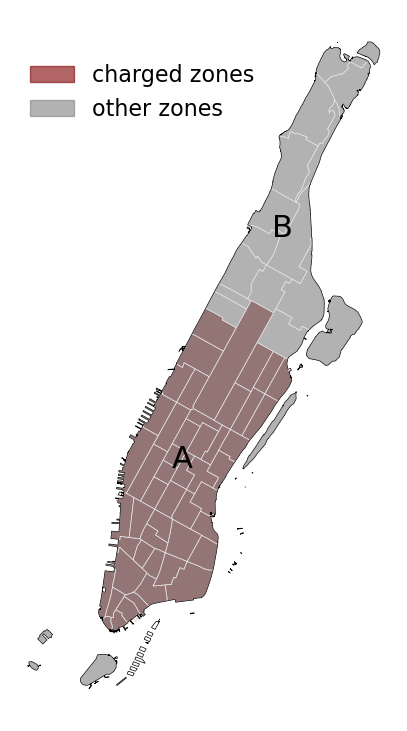

In [36]:
fig,ax = plt.subplots(figsize=(5,10))
ctz.plot( ax = ax,  linewidth = 0.5, edgecolor = 'white', facecolor = 'maroon', label = 'taxi zones in manhattan',alpha = 0.6)
tz[tz.borough == 'Manhattan'].plot( ax = ax, color = 'grey', linewidth = 0.5, edgecolor = 'white',label = 'taxi zones in manhattan', alpha = 0.6)
nyc[nyc['boro_code'] == '1'].plot(ax = ax, edgecolor = 'k', facecolor = 'None', linewidth = 0.5 , label = 'manhattan')

# Create legend patches
patch0 = Patch(color='white', label='')
patch1 = Patch(color='maroon', label='charged zones',alpha = 0.6)
patch2 = Patch(color='grey', label='other zones',alpha = 0.6)

# Add the legend to the plot
legend = ax.legend(handles=[patch0,patch1, patch2], loc='upper left', title='',frameon=False,fontsize=16)

# Add text annotations 
ax.text(-73.99, 40.75, 'A', fontsize=22, color='black') 
ax.text(-73.95, 40.82, 'B', fontsize=22, color='black') 

plt.axis('off')
plt.show()

# 2. trends plot

In [6]:
def prepare_data(df, group_boundary, general_model):
    # filer data.
    sdf = df[df.group3 <= group_boundary]
    if general_model:
        sdf = pd.concat([df[df.date.isin(['2018-10-29', '2017-10-30'])], sdf])
    else:
        sdf = pd.concat([df[df.date == '2018-10-29'], sdf])
    
    sdf['PUn_trips'] = sdf['PUn_trips_tx'] + sdf['PUn_trips_ub'] + sdf['PUn_trips_lf']
    grouped_data = sdf.groupby(by=['date', 'TMT'], as_index=False).agg(
        {'PUn_trips': 'mean', 'PUn_trips_tx': 'mean', 'PUn_trips_lf': 'mean', 'PUn_trips_ub': 'mean'}
    )
    return pd.concat([grouped_data[grouped_data['TMT'] == 0].reset_index(drop=True),
                      grouped_data[grouped_data['TMT'] == 1].reset_index(drop=True)], axis=1)


def plot_subplot(ax, x, y1, y2, color1, color2, label1, label2, ylim, cent_idx):
    # plot with two data series.
    ax.plot(x, y1, 'o-', color=color1, label=label1, linewidth=3, markersize=8)
    ax.plot(x, y2, 'o-', color=color2, label=label2, linewidth=3, markersize=8)
    ax.set_ylim(ylim)
    ax.axvline(x=cent_idx, linestyle="--", color='red', linewidth=2)
    ax.tick_params(axis='y', labelsize=20)
    ax.legend(loc='upper right', fontsize=16)

    
def plot_trends(p, cent_index, general_model):
    # rules set up for plot
    plot_list = ['PUn_trips_t', 'PUn_trips_tx_t', 'PUn_trips_lf_t', 'PUn_trips_ub_t', 
                 'PUn_trips_c', 'PUn_trips_tx_c', 'PUn_trips_lf_c', 'PUn_trips_ub_c']
    colors = ['blue', 'dodgerblue', 'orange', 'gold', 'k', 'darkslategrey', 'indigo', 'm']
    labels = ['Ride-hailing Tmt.', 'Ride-hailing Ctl.', 'Taxi Tmt.', 'Taxi Ctl.', 
              'Uber Tmt.', 'Uber Ctl.', 'Lyft Tmt', 'Lyft Ctl.']
    x = np.arange(-30, 30, 1)
    ylim_values = [(80, 220) if general_model else (0, 265), (40, 125) if general_model else (0, 125), (0, 120),(0, 40)]
    
    fig, axs = plt.subplots(4, 1, figsize=(20, 16), sharex=True)
    for i, ax in enumerate(axs):
        plot_subplot(ax, x, p[plot_list[i]], p[plot_list[i+4]], colors[i*2], colors[i*2+1], labels[i*2], labels[i*2+1], ylim_values[i], cent_index)
        ax.set_ylabel('hourly pick-ups', fontsize=20)
        if i < 3:
            ax.tick_params(labelbottom=False)
        else:
            ticks = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
            tick_labels = [f"day {i}" for i in ticks]
            ax.set_xticks(ticks)
            ax.set_xticklabels(tick_labels, fontsize=16, rotation=40)
            ax.tick_params(axis='y', labelsize=16)

    plt.subplots_adjust(hspace=0.1)
    plt.show()

    
def trend_plot(df, group_boundary, cent_index, general_model=False):
    # main plot function
    print(f"Groups: {df.group3.unique()}")
    prepared_data = prepare_data(df, group_boundary, general_model)
    print(f"Dates: {prepared_data['date_c'].nunique()}, Range: {prepared_data['date_c'].min()} to {prepared_data['date_c'].max()}")
    plot_trends(prepared_data, cent_index, general_model)

[100  90  80  70  60  50  40  35  30  25  20 110]
120 2017-10-30 2019-03-29
(60, 12)


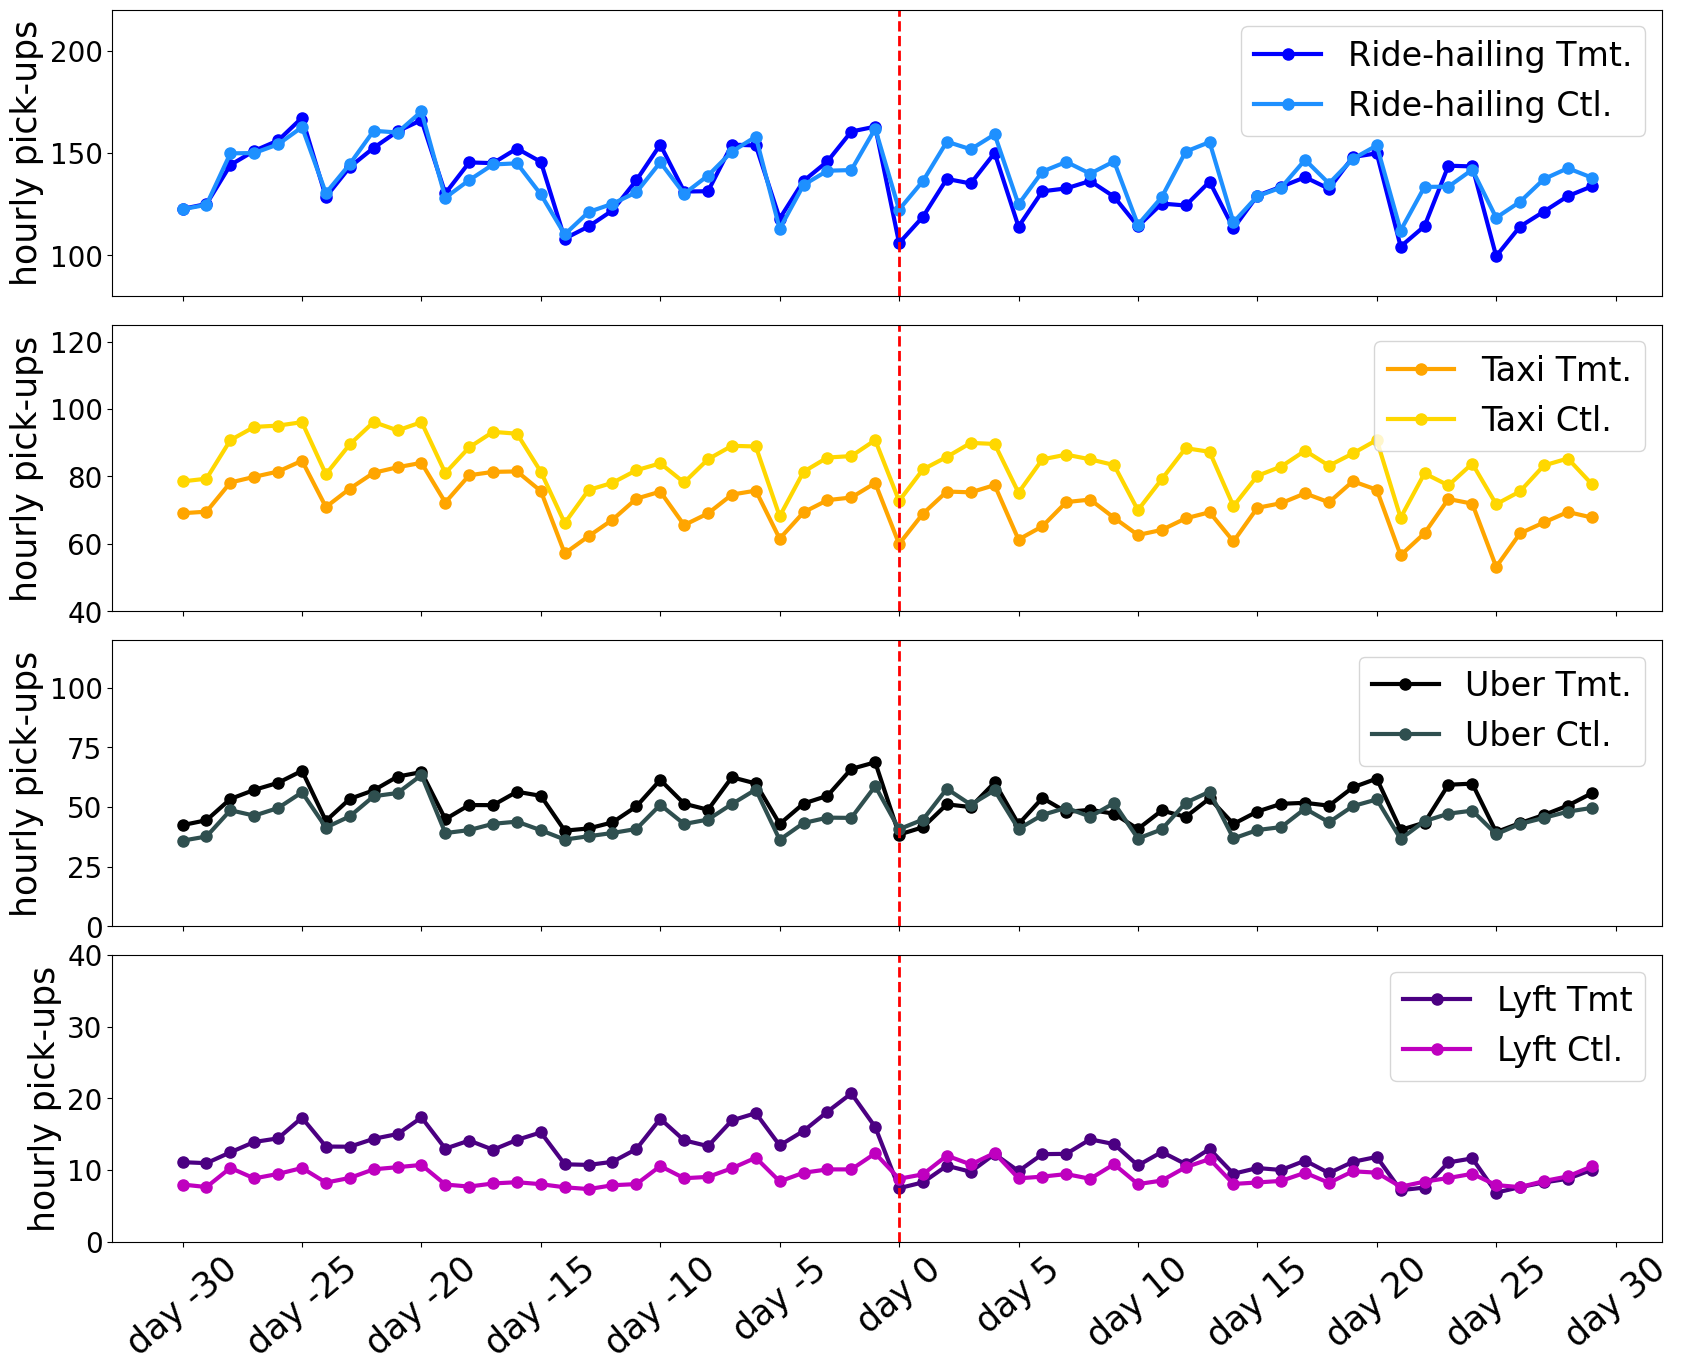

In [7]:
g = pd.read_csv('data/clean/finalUsed/csvForStata/ultx_twoyears_v6.csv', index_col = 0)
trend_plot(g, 30, 0, general_model = True)

# 3. policy effectivenss 

In [25]:
# Constants
horizontal_line_width = 0.08
bar_color_lists = ['gold', 'darkslategrey', 'm']
center_color_lists = ['orange', 'k', 'indigo']
dash_color = "red"

# auxiliary functions

# CI plot.
def plot_confidence_interval(ax, x, x_mean, x_top, x_bottom, bar_color, center_color):
    left, right = x - horizontal_line_width / 2, x + horizontal_line_width / 2
    ax.plot([x, x], [x_top, x_bottom], color=bar_color, linewidth=3)
    ax.plot([left, right], [x_top, x_top], color=bar_color, linewidth=3)
    ax.plot([left, right], [x_bottom, x_bottom], color=bar_color, linewidth=3)
    ax.plot(x, x_mean, 'd', color=center_color, markersize=10)

# data pre-processing.
def pre_process(df, did_types, trip_types):
    temp = df[(df.did_type == did_types) & (df.trip_type == trip_types)].reset_index(drop=True)
    temp['coef_regular'] = np.exp(temp['coefficient']) - 1
    temp['coef_bottom'] = np.exp(temp['p_l']) - 1
    temp['coef_top'] = np.exp(temp['p_r']) - 1
    return temp

# set rules for subplots.
def setup_subplot(ax, x, y_data, y_b, y_t, bar_col, center_col, label, ylim, xlabel, ylabel, x_ticks, y_formatter=None):
    for idx, y in enumerate(y_data):
        plot_confidence_interval(ax, x[idx], y, y_b[idx], y_t[idx], bar_col, center_col)
    ax.set_ylim(ylim)
    ax.grid(True, color='grey', linestyle='--', linewidth=0.5)
    ax.axhline(y=0, linestyle="--", color=dash_color, linewidth=1.5)
    ax.plot([0.1, 0.1], [1, 1], color=bar_col, label=label + ' CI', linewidth=2)
    ax.plot(1, 1, 'd', color=center_col, markersize=6, label=label + ' Coef')
    if y_formatter:
        ax.yaxis.set_major_formatter(y_formatter)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks, fontsize=15)
    ax.set_xlabel(xlabel, fontsize=19)
    ax.set_ylabel(ylabel, fontsize=19)

# plot function.
def plot_effect(df, title, x_label, y_label, bot_plot, top_plot, did_types, x_ticks, y_formatter=mtick.PercentFormatter(1.0), extra_label = False):
    trip_type_lists = ['tx', 'ub', 'lf']
    types = ['Taxi', 'Uber', 'Lyft']
    fig, axs = plt.subplots(1, 3, figsize=(23, 5), sharey=True)
    for ii, (trip_type, label, bar_col, center_col) in enumerate(zip(trip_type_lists, types, bar_color_lists, center_color_lists)):
        temp_df = pre_process(df, did_types, trip_type)
        x = list(range(temp_df.shape[0]))
        y = temp_df['coef_regular'].round(3).tolist()
        y_b = temp_df['coef_bottom'].round(3).tolist()
        y_t = temp_df['coef_top'].round(3).tolist()
        
        setup_subplot(axs[ii], x, y, y_b, y_t, bar_col, center_col, label, (bot_plot, top_plot), x_label, '', x_ticks, y_formatter)
        axs[ii].set_title(label, fontsize=18)
    
    if extra_label:
        legend_labels = ['1: no substitutes', '2: subway only', '3: citi bike only', '4: both available']
        custom_lines = [plt.Line2D([0], [0], color='w', lw=0)] * 4
        fig.legend(custom_lines, legend_labels, loc='center right',  title='Categories', fontsize=16,title_fontsize = 18, frameon=False)
    
    fig.text(0.07, 0.5, y_label, va='center', rotation='vertical', fontsize=18)
    plt.subplots_adjust(wspace=0.05)
    plt.suptitle(title, fontsize=20)
    plt.show()

## alternative travel modes

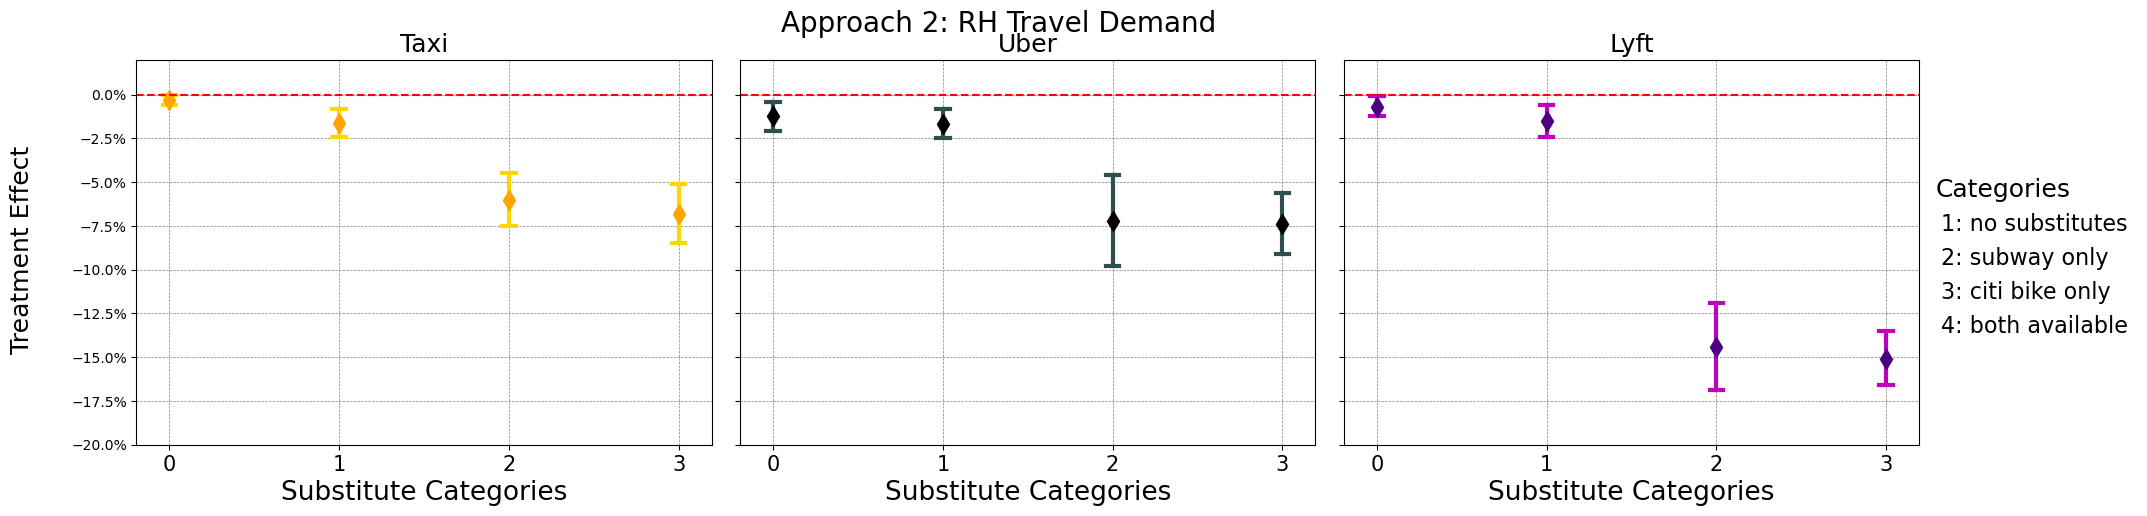

In [26]:
a = pd.read_csv('data/clean/finalUsed/stataResult/treatment_effect_substitutes_v2.csv')
plot_effect(a, 'Approach 2: RH Travel Demand', 'Substitute Categories', \
            'Treatment Effect', -0.20, 0.02, 'general', x_ticks=[0,1,2,3], extra_label = True)

## policy heterogeneity 

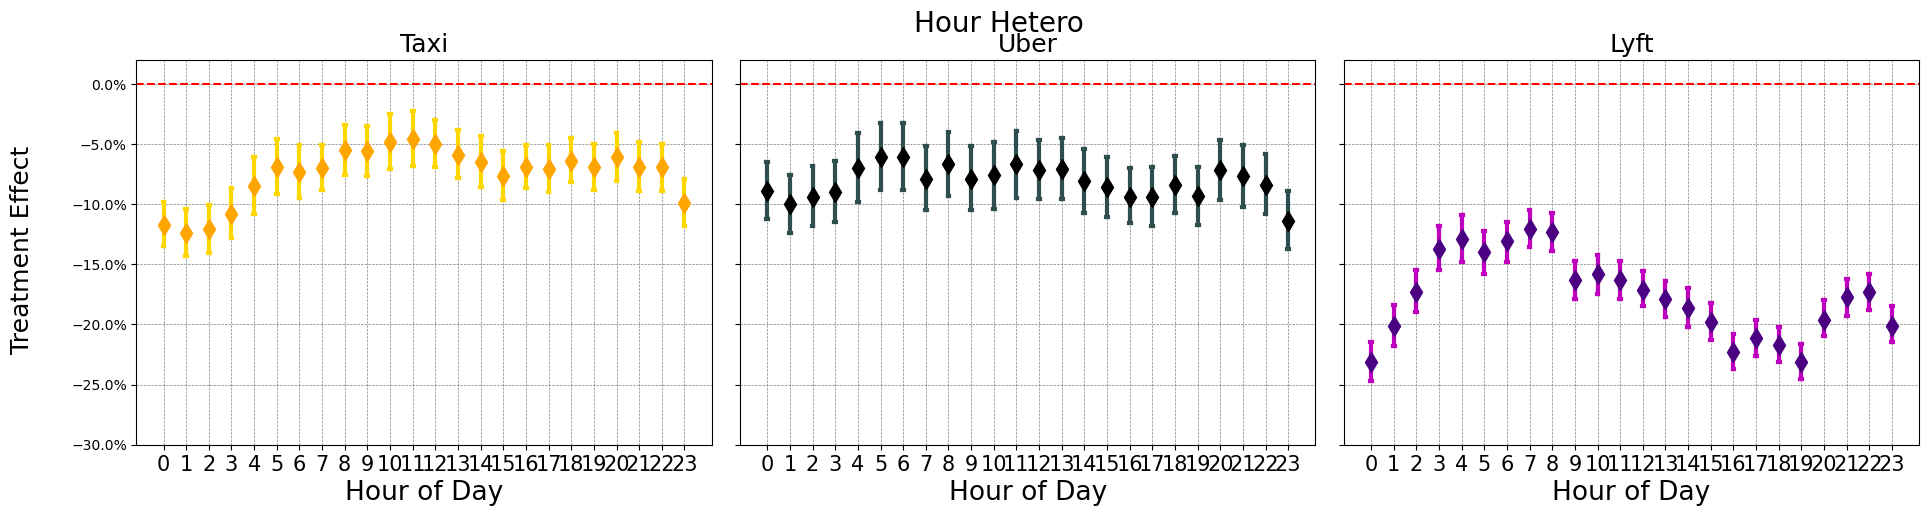

In [27]:
h = pd.read_csv('data/clean/finalUsed/stataResult/hour_hetero_ultx_v2.csv')
plot_effect(h, "Hour Hetero", "Hour of Day", "Treatment Effect", -0.30, 0.02, 'general', x_ticks=list(range(24)))

# 4. appendix figures

## spatial heterogeneity
- ride-hailing zone level 

In [24]:
# spatial heterogeneity file
tf = pd.read_csv("data/clean/finalUsed/stataResult/ride_hailing_zone_hetero.csv")
gtf = tz[['location_i','geometry']].merge(tf, left_on = 'location_i',right_on = 'location_i', how = 'inner')

# charged zones boundary
ctzb= gpd.read_file('data/shapefile/NYCTaxiZones/congestedBoundary.shp')
# print(ctzb.crs)

(66, 9)


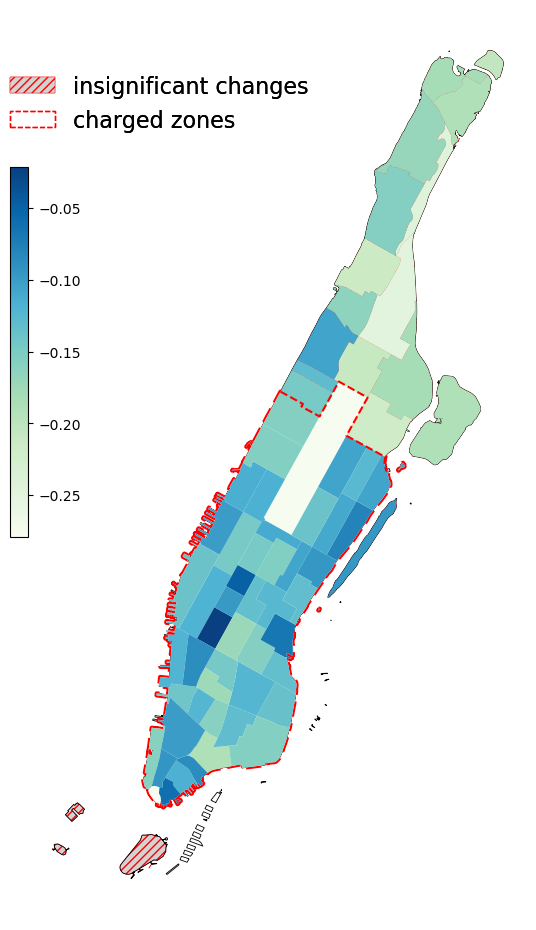

In [126]:
fig, ax = plt.subplots(figsize=(8, 16))

# Plotting layers with improved readability
tz.plot(ax=ax, facecolor='lightgrey', edgecolor='red', hatch='////', linewidth=0.3)
nyc[nyc['boro_code'] == '1'].plot(ax=ax, edgecolor='k', facecolor='None', linewidth=0.6)
gtf.plot(ax=ax, column='coefficient', cmap='GnBu', legend=True, legend_kwds={'orientation': "vertical"})
ctzb.plot(ax=ax, color='red', linewidth=1.5, linestyle='--')

# Create legend patches 
patch0 = Patch(facecolor='lightgrey', edgecolor='red', hatch='////', linewidth=0.3, label='insignificant changes')
patch1 = Patch(facecolor='None', edgecolor='red', linewidth=1.5, linestyle='--', label='charged zones')

# Add the legend with labels and layout
legend = ax.legend(handles=[patch0, patch1], loc='upper left', title='', frameon=False, fontsize=16, bbox_to_anchor=(-0.08, 0.95))
ax.add_artist(legend)

# Access and adjust the color bar position and size for better visibility
cax = ax.get_figure().get_axes()[1] 
box = cax.get_position()
new_width = box.width * 0.5  
new_height = box.height * 0.35  
cax.set_position([0.1, 0.45, new_width, new_height]) 

# Final touches
plt.axis('off')
plt.show()

## correlation plot

0.5296565652344354 4.807562903338904e-06


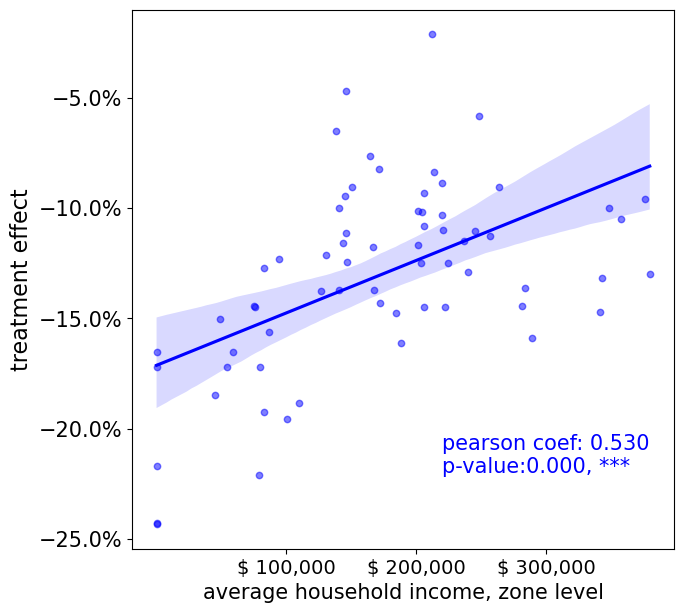

In [145]:
# Compute Pearson correlation and p-value
temp = gtf.merge(tz[['location_i', 'mean_inc']], left_on='location_i', right_on='location_i', how='inner')
temp['coef_regular'] = np.exp(temp['coefficient']) - 1
pearson_coef, p_value = stats.pearsonr(temp['mean_inc'], temp['coef_regular'])
print(pearson_coef, p_value)

# Plot with regression line
fig, ax = plt.subplots(figsize=(7, 7))
sns.regplot(x=temp['mean_inc'], y=temp['coef_regular'], color='blue', marker='o', scatter_kws={'s':21, 'alpha':0.5})

# Display Pearson correlation and p-value with improved placement
plt.text(200000, -0.25, f'pearson coef: {pearson_coef:.3f}\nP-value: {p_value:.3f}, ***', color='blue', size=14)

# Formatting the y-axis to show percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.tick_params(axis='y', labelsize=15)

# Format x-axis ticks and labels for clarity
ticks = [100000, 200000, 300000]
ticks_label = ['$100,000', '$200,000', '$300,000']
plt.xticks(ticks, ticks_label, fontsize=14, rotation=0)
plt.xlabel('average household income, zone level', size=15)
plt.ylabel('treatment effect', size=16)

plt.show()